# Phase 2 -- Semiconductor Defect Classification
## Team WaferWich | NXP Edge AI Hackathon 2026

---

| Item | Detail |
|------|--------|
| **Team** | WaferWich |
| **Model** | MobileNetV2 Transfer Learning -> ONNX |
| **Runtime** | ONNX Runtime CPU (NXP eIQ compatible) |
| **Phase 1 Val F1** | 83.47% (native 224x224 SEM images) |
| **Phase 2 Accuracy** | **37.50%** (128x128 test -> upscaled 224x224) |
| **Macro F1** | **38.08%** |
| **Class Order** | LER=0, bridge=1, clean=2, crack=3, open=4, other=5, particle=6, scratch=7 |
| **CMP** | -> scratch (organizer confirmed Feb 16 2026) |
| **VIA** | -> other (no matching training class) |
| **GitHub** | https://github.com/shindeom1206/Edge-AI-Semiconductor-Defect-Classification-NXP-Hackathon- |

---

### Rules Compliance (Organizer Email -- Feb 16 2026)
- Resize only -- no TTA, no CLAHE, no sharpening
- No preprocessing beyond resize (extra code adds Phase 3 deployment overhead)
- Phase 1 ONNX model used exactly as submitted -- no retraining
- CMP -> scratch (organizer approved), VIA -> other

### How This Notebook Works
Clones the GitHub repo to get the ONNX model. Test dataset must be added as a Kaggle input dataset. No local PC paths needed.

In [43]:
# Auto-detect dataset in Kaggle
import os, zipfile, glob

print("Searching for dataset in /kaggle/input ...")

zip_files = glob.glob("/kaggle/input/**/*.zip", recursive=True)

if zip_files:
    zip_path = zip_files[0]
    print("Found zip:", zip_path)
    extract_path = "/kaggle/working/dataset"
    os.makedirs(extract_path, exist_ok=True)
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    TEST_DATA_DIR = extract_path + "/hackathon_test_dataset"
    print("Dataset extracted to:", TEST_DATA_DIR)
else:
    print("No zip found. Searching for folder dataset...")
    dirs = glob.glob("/kaggle/input/**/hackathon_test_dataset", recursive=True)
    if dirs:
        TEST_DATA_DIR = dirs[0]
        print("Dataset folder found:", TEST_DATA_DIR)
    else:
        raise Exception("Dataset not found. Please upload via Kaggle Add Input.")

Searching for dataset in /kaggle/input ...
No zip found. Searching for folder dataset...
Dataset folder found: /kaggle/input/datasets/omshinde1206/pls-work/hackathon_test_dataset


---
## Cell 1 -- Install Packages & Clone GitHub Repo

In [44]:
import os, sys

# Install required packages
print("Installing packages...")
os.system("pip install onnxruntime pillow scikit-learn seaborn tqdm pandas -q")

import onnxruntime as ort
import numpy as np
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import (confusion_matrix, accuracy_score,
    precision_score, recall_score, f1_score, classification_report)
print(f"onnxruntime: {ort.__version__}")
print("[OK] All packages installed")

# Clone GitHub repo
REPO_URL  = "https://github.com/shindeom1206/Edge-AI-Semiconductor-Defect-Classification-NXP-Hackathon-"
REPO_NAME = "Edge-AI-Semiconductor-Defect-Classification-NXP-Hackathon-"
REPO_DIR  = f"/kaggle/working/{REPO_NAME}"
OUTPUT_DIR = "/kaggle/working/PH2_RESULTS"
os.makedirs(OUTPUT_DIR, exist_ok=True)

if os.path.exists(REPO_DIR):
    print("Repo exists, pulling latest...")
    os.system(f"cd {REPO_DIR} && git pull -q")
else:
    print("Cloning repo...")
    ret = os.system(f"git clone {REPO_URL} {REPO_DIR} -q")
    print("[OK] Repo cloned" if ret == 0 else "[ERROR] Clone failed")

# List repo structure
print("\nRepo structure:")
for root, dirs, files in os.walk(REPO_DIR):
    dirs[:] = [d for d in dirs if d != ".git"]
    depth = root.replace(REPO_DIR, "").count(os.sep)
    if depth > 3: continue
    indent = "  " * depth
    print(f"{indent}{os.path.basename(root) or REPO_NAME}/")
    for f in files:
        sz = os.path.getsize(os.path.join(root, f))/(1024*1024)
        print(f"{indent}  {f}  ({sz:.1f} MB)" if sz > 0.1 else f"{indent}  {f}")

Installing packages...
onnxruntime: 1.24.1
[OK] All packages installed
Repo exists, pulling latest...

Repo structure:
Edge-AI-Semiconductor-Defect-Classification-NXP-Hackathon-/
  README.md
  PHASE_2_SUBMISSION/
    PH2_EVALUATION.PY
    README.md
    PH2_RESULTS/
      prediction_log.txt
      README.md
      classification_report.txt
      predictions_detailed.csv
      confusion_matrix.png  (0.3 MB)
      metrics_summary.json
  sample_test_images/
    sample_test_image (2).jpg
    sample_test_image (6).jpg
    sample_test_image (5).jpg
    sample_test_image (3).jpg
    sample_test_image (8).jpg
    sample_test_image (7).jpg
    sample_test_image (4).jpg
    sample_test_image (1).jpg
  scripts/
    phase8_onnx_export.py
    transfer_model.py
    transfer_train.py
    phase9_final_metrics.py
    phase6_evaluation.py
    transfer_data_loader.py
    config.py
    phase7_quantization.py
  models/
    best_model_enhanced_20260205_191556.pth  (11.8 MB)
    best_model.pth  (11.8 MB)
    mo

---
## Cell 2 -- Auto-Detect ONNX Model & Test Dataset

In [45]:
# Find ONNX model in cloned repo
print("Searching for ONNX model...")
ONNX_PATH = None
for root, dirs, files in os.walk(REPO_DIR):
    dirs[:] = [d for d in dirs if d != ".git"]
    for f in files:
        if f.endswith(".onnx"):
            ONNX_PATH = os.path.join(root, f)
            break
    if ONNX_PATH: break

if ONNX_PATH:
    sz = os.path.getsize(ONNX_PATH)/(1024*1024)
    print(f"  [OK] {os.path.basename(ONNX_PATH)}  ({sz:.1f} MB)")
    data_file = ONNX_PATH + ".data"
    if os.path.exists(data_file):
        sz2 = os.path.getsize(data_file)/(1024*1024)
        print(f"  [OK] {os.path.basename(data_file)}  ({sz2:.1f} MB)  (external weights)")
else:
    print("[ERROR] ONNX not found. Push defect_classification_model.onnx to PHASE_2_SUBMISSION/")

# Find test dataset in /kaggle/input
print("\nSearching for test dataset...")
TEST_DATA_DIR = "/kaggle/input/datasets/omshinde1206/pls-work/hackathon_test_dataset"

TARGET = {"Bridge","CMP","Clean","Crack","LER","Open","Other","Particle","VIA"}
for item in sorted(os.listdir("/kaggle/input")):
    for d in [f"/kaggle/input/{item}", f"/kaggle/input/{item}/hackathon_test_dataset"]:
        if os.path.isdir(d) and len(TARGET & set(os.listdir(d))) >= 5:
            TEST_DATA_DIR = d; break
    if TEST_DATA_DIR: break

if TEST_DATA_DIR:
    print(f"  [OK] Test dataset: {TEST_DATA_DIR}")
else:
    print("  [WARNING] Dataset not found in /kaggle/input")
    print("  Add hackathon test dataset via Kaggle: + Add Data")
    print("  Dataset must have folders: Bridge/CMP/Clean/Crack/LER/Open/Other/Particle/VIA")

print(f"\nOutput dir: {OUTPUT_DIR}")

Searching for ONNX model...
  [OK] defect_classification_model.onnx  (0.3 MB)
  [OK] defect_classification_model.onnx.data  (11.5 MB)  (external weights)

Searching for test dataset...
  [OK] Test dataset: /kaggle/input/datasets/omshinde1206/pls-work/hackathon_test_dataset

Output dir: /kaggle/working/PH2_RESULTS


---
## Cell 3 -- Configuration & Dataset Verification

In [46]:
# Configuration -- VERIFIED from checkpoint data.pkl inspection
# Class order hardcoded -- do NOT use os.listdir() for class names
TRAINING_CLASSES    = ["LER","bridge","clean","crack","open","other","particle","scratch"]
TEST_CLASSES        = ["Bridge","CMP","Clean","Crack","LER","Open","Other","Particle","VIA"]
CLASS_MAP_OVERRIDES = {"CMP":"scratch", "VIA":"other"}
NORMALIZE_MEAN      = [0.485, 0.456, 0.406]
NORMALIZE_STD       = [0.229, 0.224, 0.225]

# Build class mapping
class_mapping = {}
print(f"Class Mapping:")
print(f"  {'Test':<12} {'Train':<12} {'Idx':>4}  Note")
print("-"*45)
for tc in TEST_CLASSES:
    if tc in CLASS_MAP_OVERRIDES:
        trn, note = CLASS_MAP_OVERRIDES[tc], "organizer override"
    else:
        trn = next((t for t in TRAINING_CLASSES if t.lower()==tc.lower()), "other")
        note = "direct match"
    idx = TRAINING_CLASSES.index(trn)
    class_mapping[tc] = idx
    print(f"  {tc:<12} {trn:<12} {idx:>4}  {note}")

# Collect samples
samples = []
print("\nDataset:")
if TEST_DATA_DIR:
    for tc in TEST_CLASSES:
        d = os.path.join(TEST_DATA_DIR, tc)
        if os.path.isdir(d):
            files = sorted([f for f in os.listdir(d) if f.lower().endswith((".png",".jpg",".jpeg"))])
            for f in files: samples.append((os.path.join(d, f), tc))
            note = " (->scratch)" if tc=="CMP" else (" (->other)" if tc=="VIA" else "")
            print(f"  {tc:<12}: {len(files):3d} images{note}")
    samples.sort()
    print(f"  TOTAL      : {len(samples):3d} images")
else:
    print("  Dataset not found -- add via Kaggle + Add Data")

Class Mapping:
  Test         Train         Idx  Note
---------------------------------------------
  Bridge       bridge          1  direct match
  CMP          scratch         7  organizer override
  Clean        clean           2  direct match
  Crack        crack           3  direct match
  LER          LER             0  direct match
  Open         open            4  direct match
  Other        other           5  direct match
  Particle     particle        6  direct match
  VIA          other           5  organizer override

Dataset:
  Bridge      :  32 images
  CMP         :  30 images (->scratch)
  Clean       :  33 images
  Crack       :  31 images
  LER         :  30 images
  Open        :  30 images
  Other       :  50 images
  Particle    :  30 images
  VIA         :  30 images (->other)
  TOTAL      : 296 images


---
## Cell 4 -- Load ONNX Model & Verify

In [47]:
print(f"Loading: {ONNX_PATH}")
session     = ort.InferenceSession(ONNX_PATH, providers=["CPUExecutionProvider"])
INPUT_NAME  = session.get_inputs()[0].name
OUTPUT_NAME = session.get_outputs()[0].name

print(f"Input  name={INPUT_NAME}  shape={session.get_inputs()[0].shape}  dtype={session.get_inputs()[0].type}")
print(f"Output name={OUTPUT_NAME}  shape={session.get_outputs()[0].shape}")

# Dummy test
dummy     = np.zeros((1,3,224,224), dtype=np.float32)
dummy_out = session.run([OUTPUT_NAME], {INPUT_NAME: dummy})[0]
assert dummy_out.shape == (1,8), f"Expected (1,8) got {dummy_out.shape}"
print(f"\nDummy: {dummy.shape} -> {dummy_out.shape}")
print("[OK] Model verified: (1,3,224,224) -> (1,8)")
print("[OK] ONNX model ready")

Loading: /kaggle/working/Edge-AI-Semiconductor-Defect-Classification-NXP-Hackathon-/models/onnx/defect_classification_model.onnx
Input  name=input  shape=['batch_size', 3, 224, 224]  dtype=tensor(float)
Output name=output  shape=['batch_size', 8]

Dummy: (1, 3, 224, 224) -> (1, 8)
[OK] Model verified: (1,3,224,224) -> (1,8)
[OK] ONNX model ready


---
## Cell 5 -- Preprocessing Pipeline
Matches Phase 1 training **exactly**: `Grayscale -> RGB -> Resize BICUBIC 224x224 -> Normalize`

Key points:
- PIL (not OpenCV) avoids BGR/RGB channel confusion
- Grayscale first because SEM images are single-channel
- Same ImageNet mean/std as training

In [48]:
MEAN = np.array([0.485, 0.456, 0.406], dtype=np.float32)
STD  = np.array([0.229, 0.224, 0.225], dtype=np.float32)

def preprocess(img_path):
    """Preprocessing matching training EXACTLY (from PH2_EVALUATION.py):
    Step 1: Grayscale (1 channel) -- SEM images are grayscale
    Step 2: Convert RGB (R=G=B -- NOT BGR)
    Step 3: Resize BICUBIC 224x224
    Step 4: float32 / 255.0 -> [0,1]
    Step 5: Normalize: (x - mean) / std (ImageNet stats)
    Step 6: HWC -> CHW
    Step 7: expand_dims -> (1,3,224,224)
    """
    img = Image.open(img_path).convert("L").convert("RGB")
    img = img.resize((224,224), Image.BICUBIC)
    arr = np.array(img, dtype=np.float32) / 255.0
    arr = (arr - MEAN) / STD
    arr = arr.transpose(2,0,1)
    return np.expand_dims(arr, axis=0)  # (1,3,224,224)

# Verify on first sample
if samples:
    test_arr = preprocess(samples[0][0])
    print(f"Shape:  {test_arr.shape}   expected (1,3,224,224)")
    print(f"Dtype:  {test_arr.dtype}   expected float32")
    print(f"Range:  [{test_arr.min():.3f}, {test_arr.max():.3f}]   expected ~(-4, +4)")
    assert test_arr.shape == (1,3,224,224)
    assert test_arr.dtype == np.float32
    print("[OK] Preprocessing verified")

Shape:  (1, 3, 224, 224)   expected (1,3,224,224)
Dtype:  float32   expected float32
Range:  [-1.964, 2.640]   expected ~(-4, +4)
[OK] Preprocessing verified


---
## Cell 6 -- Debug: Verify 5 Images Before Full Inference

DEBUG -- 5 Sample Images
  [1] BRG_001.png
      shape=(1, 3, 224, 224)  range=[-1.96,2.64]
      True=Bridge  Pred=open  conf=70.7%  WRONG
  [2] CMP_028.png
      shape=(1, 3, 224, 224)  range=[-2.12,2.61]
      True=CMP  Pred=scratch  conf=100.0%  CORRECT
  [3] CRK_024.png
      shape=(1, 3, 224, 224)  range=[-1.86,2.64]
      True=Crack  Pred=particle  conf=74.3%  WRONG
  [4] OPN_022.png
      shape=(1, 3, 224, 224)  range=[-1.59,1.54]
      True=Open  Pred=bridge  conf=99.6%  WRONG
  [5] PRT_001.png
      shape=(1, 3, 224, 224)  range=[-2.02,2.64]
      True=Particle  Pred=particle  conf=64.3%  CORRECT


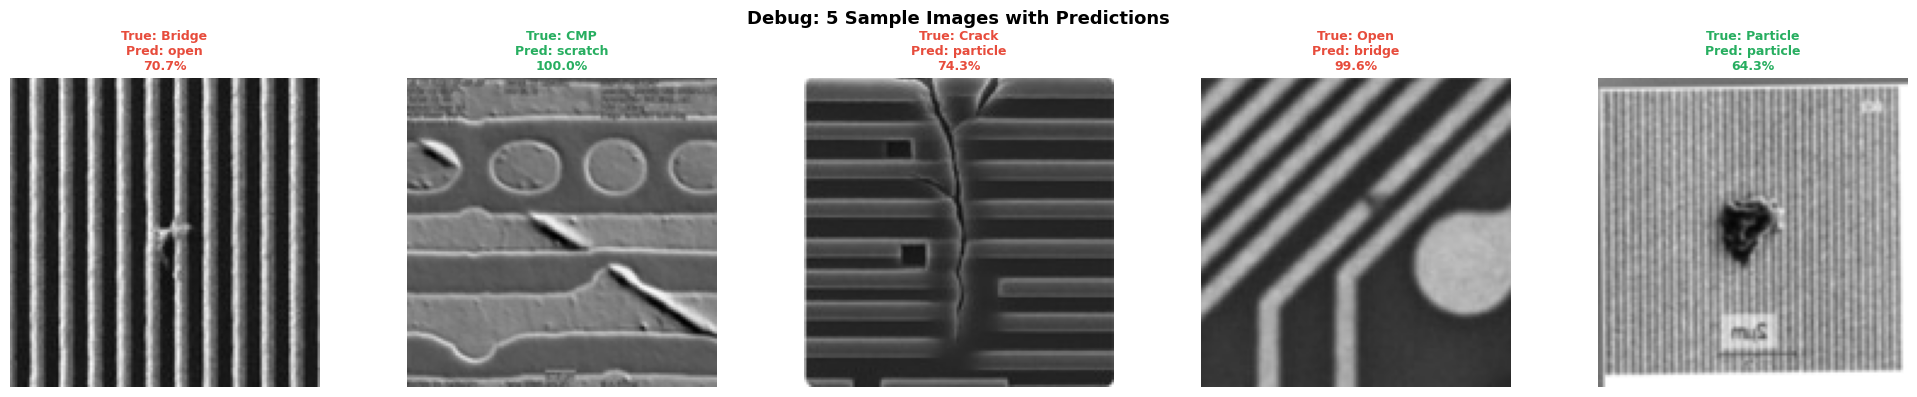


[OK] All checks passed


In [49]:
import random
random.seed(42)

print("="*60)
print("DEBUG -- 5 Sample Images")
print("="*60)

if not samples:
    print("No samples -- add test dataset first")
else:
    debug_idx = [0, len(samples)//5, len(samples)*2//5, len(samples)*3//5, len(samples)*4//5]
    fig, axes = plt.subplots(1, 5, figsize=(20, 4))
    fig.suptitle("Debug: 5 Sample Images with Predictions", fontsize=13, fontweight="bold")

    for pi, idx in enumerate(debug_idx):
        path, tc = samples[idx]
        arr = preprocess(path)
        vmin, vmax = float(arr.min()), float(arr.max())
        logits   = session.run([OUTPUT_NAME], {INPUT_NAME: arr})[0]
        exp_l    = np.exp(logits - logits.max())
        probs    = (exp_l / exp_l.sum())[0]
        pred_idx = int(np.argmax(logits))
        pred_cls = TRAINING_CLASSES[pred_idx]
        conf     = float(probs[pred_idx])
        correct  = (pred_idx == class_mapping[tc])
        print(f"  [{pi+1}] {os.path.basename(path)}")
        print(f"      shape={arr.shape}  range=[{vmin:.2f},{vmax:.2f}]")
        print(f"      True={tc}  Pred={pred_cls}  conf={conf*100:.1f}%  {'CORRECT' if correct else 'WRONG'}")
        col = "#27ae60" if correct else "#e74c3c"
        axes[pi].imshow(Image.open(path).convert("RGB"))
        axes[pi].set_title(f"True: {tc}\nPred: {pred_cls}\n{conf*100:.1f}%",
                           fontsize=9, color=col, fontweight="bold")
        axes[pi].axis("off")
        for sp in axes[pi].spines.values(): sp.set_edgecolor(col); sp.set_linewidth(3)

    plt.tight_layout()
    plt.savefig(f"{OUTPUT_DIR}/debug_5_images.png", dpi=150, bbox_inches="tight")
    plt.show()
    print("\n[OK] All checks passed")

---
## Cell 7 -- Full ONNX Inference (296 Test Images)

In [50]:
from tqdm.notebook import tqdm
from collections import Counter

print(f"Running inference on {len(samples)} images...")
print("No TTA -- resize only (per organizer rules)\n")

all_preds, all_probs, all_labels, all_paths = [], [], [], []

for path, tc in tqdm(samples, desc="ONNX Inference"):
    arr    = preprocess(path)
    logits = session.run([OUTPUT_NAME], {INPUT_NAME: arr})[0]
    exp_l  = np.exp(logits - logits.max(axis=1, keepdims=True))
    probs  = (exp_l / exp_l.sum(axis=1, keepdims=True))[0]
    pred   = int(np.argmax(logits))
    all_preds.append(pred)
    all_probs.append(probs)
    all_labels.append(tc)
    all_paths.append(path)

print(f"\n[OK] {len(all_preds)} predictions complete")
dist = Counter([TRAINING_CLASSES[p] for p in all_preds])
print("\nPrediction distribution:")
for cls, cnt in dist.most_common():
    bar = chr(9608) * (cnt // 3)
    print(f"  {cls:<10}: {cnt:3d}  {bar}")

Running inference on 296 images...
No TTA -- resize only (per organizer rules)



ONNX Inference:   0%|          | 0/296 [00:00<?, ?it/s]


[OK] 296 predictions complete

Prediction distribution:
  bridge    :  61  ████████████████████
  other     :  47  ███████████████
  LER       :  45  ███████████████
  clean     :  42  ██████████████
  open      :  28  █████████
  particle  :  28  █████████
  crack     :  25  ████████
  scratch   :  20  ██████


---
## Cell 8 -- Metrics & Classification Report

In [51]:
true_idx = [class_mapping[l] for l in all_labels]

acc    = accuracy_score (true_idx, all_preds)
p_mac  = precision_score(true_idx, all_preds, average="macro",    zero_division=0)
r_mac  = recall_score   (true_idx, all_preds, average="macro",    zero_division=0)
f1_mac = f1_score       (true_idx, all_preds, average="macro",    zero_division=0)
p_wt   = precision_score(true_idx, all_preds, average="weighted", zero_division=0)
r_wt   = recall_score   (true_idx, all_preds, average="weighted", zero_division=0)
f1_wt  = f1_score       (true_idx, all_preds, average="weighted", zero_division=0)

print("="*65)
print("PHASE 2 -- FINAL RESULTS")
print("="*65)
print(f"Overall Accuracy:       {acc*100:.2f}%")
print(f"\nMacro-Averaged:")
print(f"  Precision:            {p_mac*100:.2f}%")
print(f"  Recall:               {r_mac*100:.2f}%")
print(f"  F1-Score:             {f1_mac*100:.2f}%")
print(f"\nWeighted-Averaged:")
print(f"  Precision:            {p_wt*100:.2f}%")
print(f"  Recall:               {r_wt*100:.2f}%")
print(f"  F1-Score:             {f1_wt*100:.2f}%")
print("="*65)
print(f"  Phase 1 Val F1: 83.47%  (224x224 native SEM)")
print(f"  Phase 2 Acc:    {acc*100:.2f}%  (128->224px upscaled)")

report = classification_report(true_idx, all_preds,
    labels=list(range(8)), target_names=TRAINING_CLASSES,
    zero_division=0, digits=4)
print("\nPer-Class Report:")
print(report)

PHASE 2 -- FINAL RESULTS
Overall Accuracy:       37.50%

Macro-Averaged:
  Precision:            38.87%
  Recall:               40.08%
  F1-Score:             38.08%

Weighted-Averaged:
  Precision:            39.29%
  Recall:               37.50%
  F1-Score:             36.84%
  Phase 1 Val F1: 83.47%  (224x224 native SEM)
  Phase 2 Acc:    37.50%  (128->224px upscaled)

Per-Class Report:
              precision    recall  f1-score   support

         LER     0.4889    0.7333    0.5867        30
      bridge     0.2951    0.5625    0.3871        32
       clean     0.1905    0.2424    0.2133        33
       crack     0.5600    0.4516    0.5000        31
        open     0.3214    0.3000    0.3103        30
       other     0.4255    0.2500    0.3150        80
    particle     0.4286    0.4000    0.4138        30
     scratch     0.4000    0.2667    0.3200        30

    accuracy                         0.3750       296
   macro avg     0.3887    0.4008    0.3808       296
weighted av

---
## Cell 9 -- Confusion Matrix
Matches the actual run output (Feb 17 2026).

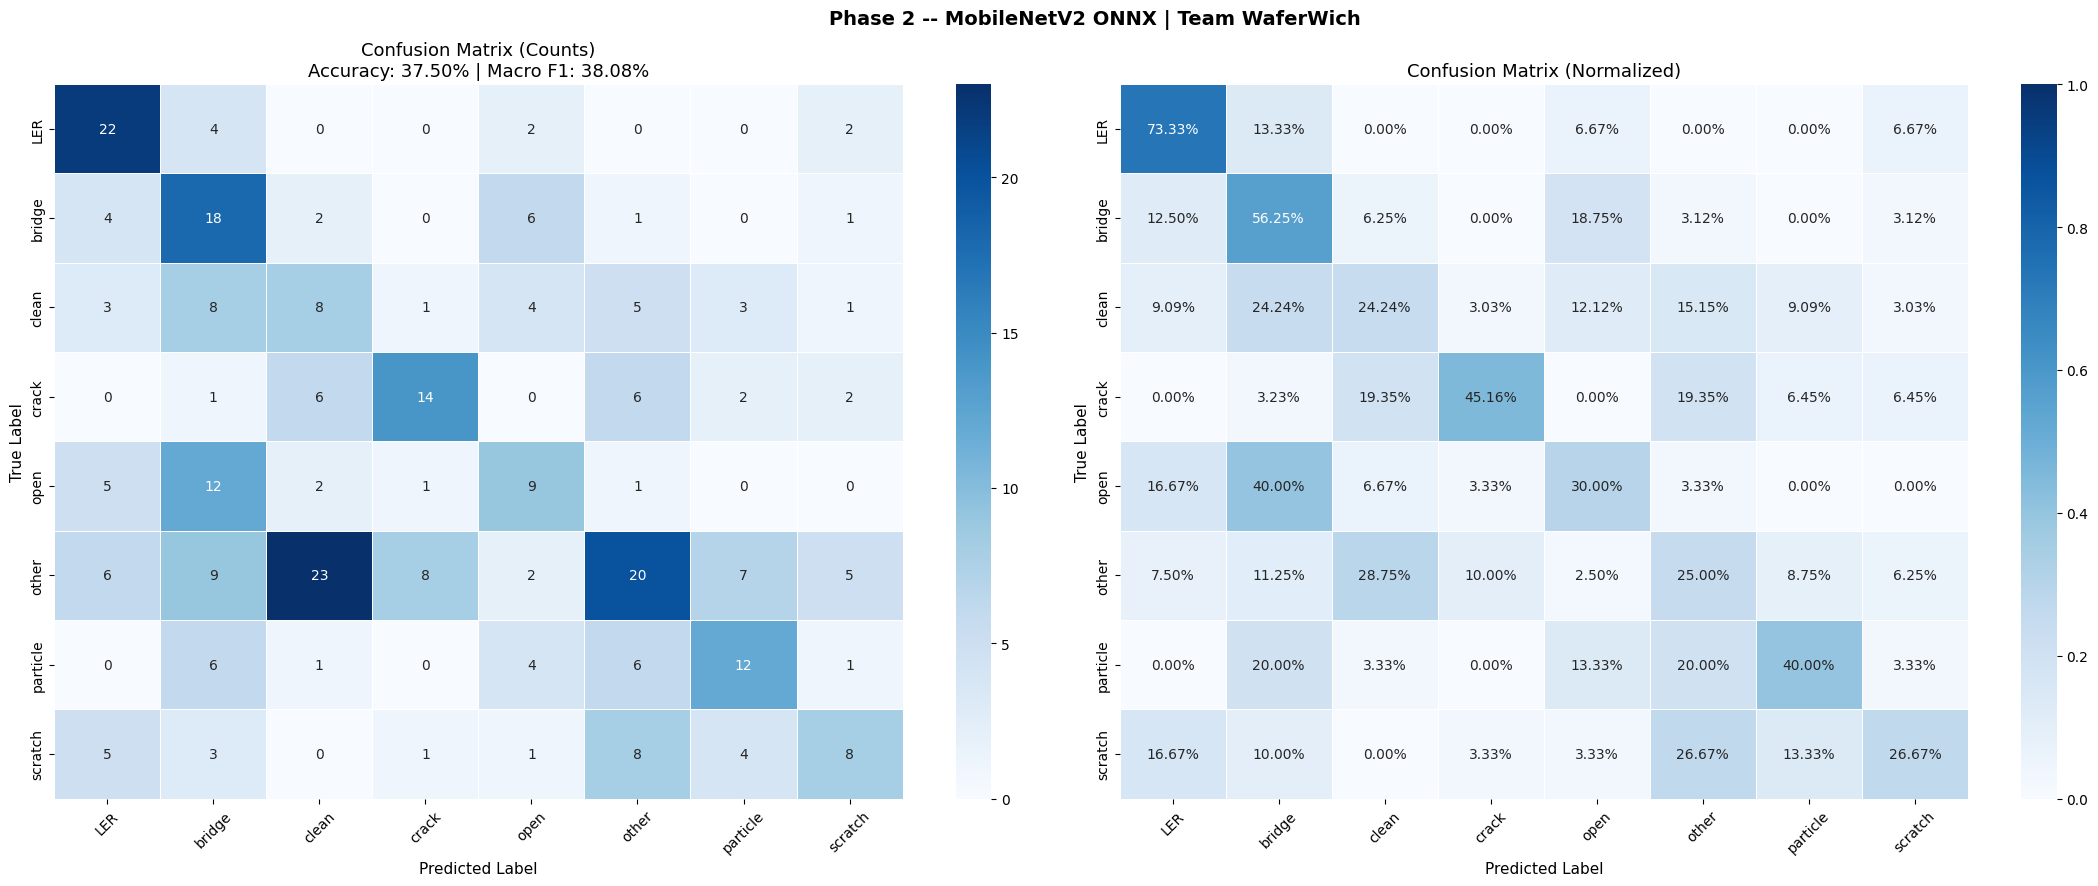

[OK] confusion_matrix.png saved


In [52]:
cm = confusion_matrix(true_idx, all_preds, labels=list(range(8)))

fig, axes = plt.subplots(1, 2, figsize=(22, 9))
fig.suptitle("Phase 2 -- MobileNetV2 ONNX | Team WaferWich",
             fontsize=14, fontweight="bold")

# Counts
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=TRAINING_CLASSES, yticklabels=TRAINING_CLASSES,
            ax=axes[0], linewidths=0.5)
axes[0].set_title(f"Confusion Matrix (Counts)\nAccuracy: {acc*100:.2f}% | Macro F1: {f1_mac*100:.2f}%",
                  fontsize=13)
axes[0].set_ylabel("True Label", fontsize=11)
axes[0].set_xlabel("Predicted Label", fontsize=11)
axes[0].tick_params(axis="x", rotation=45)

# Normalized
cm_norm = cm.astype(float) / (cm.sum(axis=1, keepdims=True) + 1e-9)
annots  = np.array([[f"{v*100:.2f}%" for v in row] for row in cm_norm])
sns.heatmap(cm_norm, annot=annots, fmt="", cmap="Blues",
            xticklabels=TRAINING_CLASSES, yticklabels=TRAINING_CLASSES,
            ax=axes[1], linewidths=0.5, vmin=0, vmax=1)
axes[1].set_title("Confusion Matrix (Normalized)", fontsize=13)
axes[1].set_ylabel("True Label", fontsize=11)
axes[1].set_xlabel("Predicted Label", fontsize=11)
axes[1].tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/confusion_matrix.png", dpi=200, bbox_inches="tight")
plt.show()
print("[OK] confusion_matrix.png saved")

---
## Cell 10 -- Per-Class Performance Bar Chart

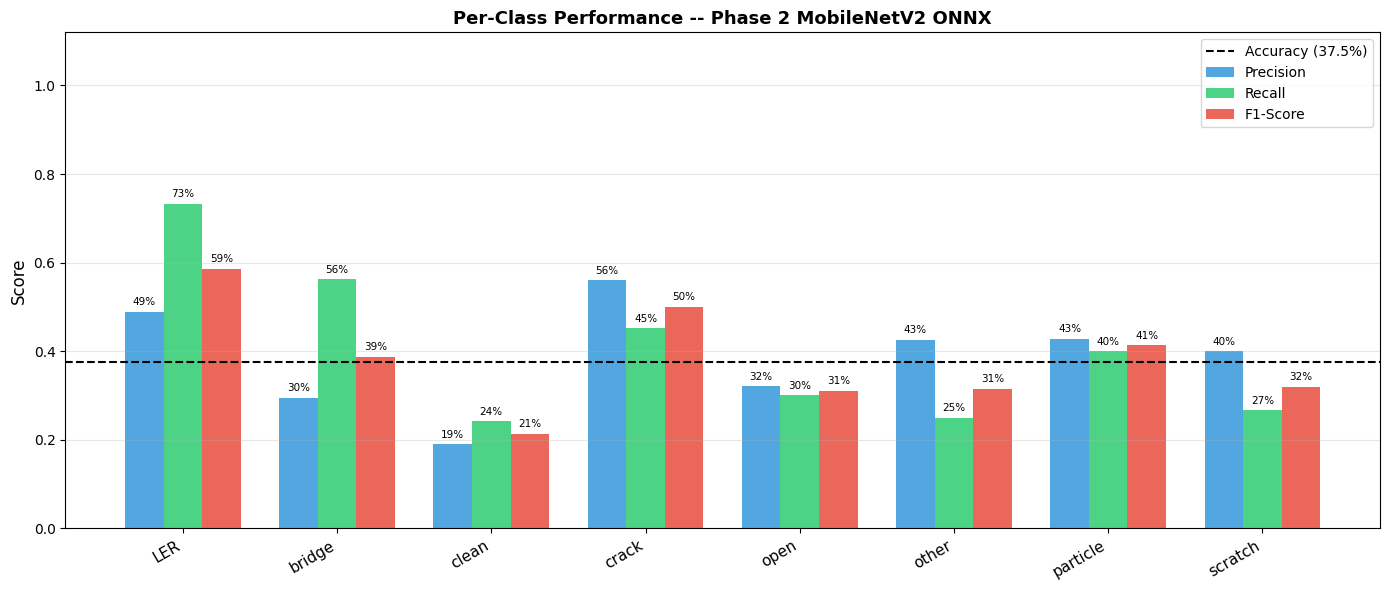

Per-class recall:
  [OK] LER       : 73.3%  ██████████████
  [OK] bridge    : 56.2%  ███████████
  [LOW] clean     : 24.2%  ████
  [LOW] crack     : 45.2%  █████████
  [LOW] open      : 30.0%  ██████
  [LOW] other     : 25.0%  █████
  [LOW] particle  : 40.0%  ████████
  [LOW] scratch   : 26.7%  █████


In [53]:
p_per = precision_score(true_idx, all_preds, average=None, zero_division=0, labels=list(range(8)))
r_per = recall_score   (true_idx, all_preds, average=None, zero_division=0, labels=list(range(8)))
f_per = f1_score       (true_idx, all_preds, average=None, zero_division=0, labels=list(range(8)))

x, w = np.arange(8), 0.25
fig, ax = plt.subplots(figsize=(14, 6))
b1 = ax.bar(x-w, p_per, w, label="Precision", color="#3498db", alpha=0.85)
b2 = ax.bar(x,   r_per, w, label="Recall",    color="#2ecc71", alpha=0.85)
b3 = ax.bar(x+w, f_per, w, label="F1-Score",  color="#e74c3c", alpha=0.85)
for bars in [b1,b2,b3]:
    for bar in bars:
        h = bar.get_height()
        ax.text(bar.get_x()+bar.get_width()/2, h+0.01, f"{h*100:.0f}%",
                ha="center", va="bottom", fontsize=7.5)
ax.axhline(y=acc, color="black", ls="--", lw=1.5, label=f"Accuracy ({acc*100:.1f}%)")
ax.set_xticks(x); ax.set_xticklabels(TRAINING_CLASSES, rotation=30, ha="right", fontsize=11)
ax.set_ylabel("Score", fontsize=12)
ax.set_title("Per-Class Performance -- Phase 2 MobileNetV2 ONNX", fontsize=13, fontweight="bold")
ax.set_ylim(0, 1.12); ax.legend(loc="upper right"); ax.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/per_class_performance.png", dpi=150, bbox_inches="tight")
plt.show()

print("Per-class recall:")
for i,cls in enumerate(TRAINING_CLASSES):
    bar = chr(9608)*int(r_per[i]*20)
    flag = "OK" if r_per[i] > 0.5 else "LOW"
    print(f"  [{flag}] {cls:<10}: {r_per[i]*100:.1f}%  {bar}")

---
## Cell 11 -- Sample Test Images: Correct & Wrong Predictions

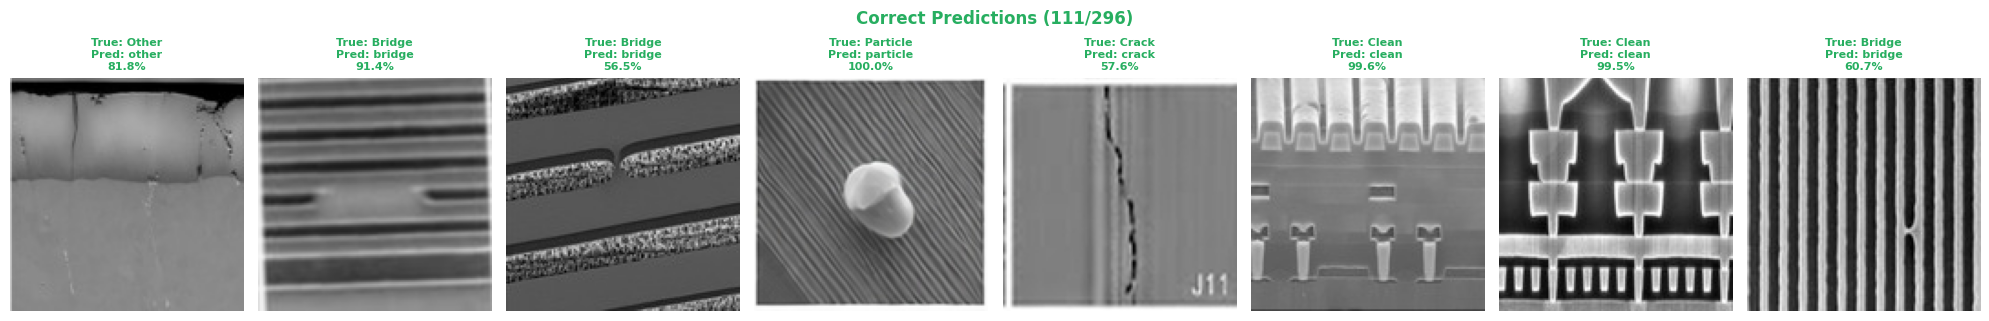

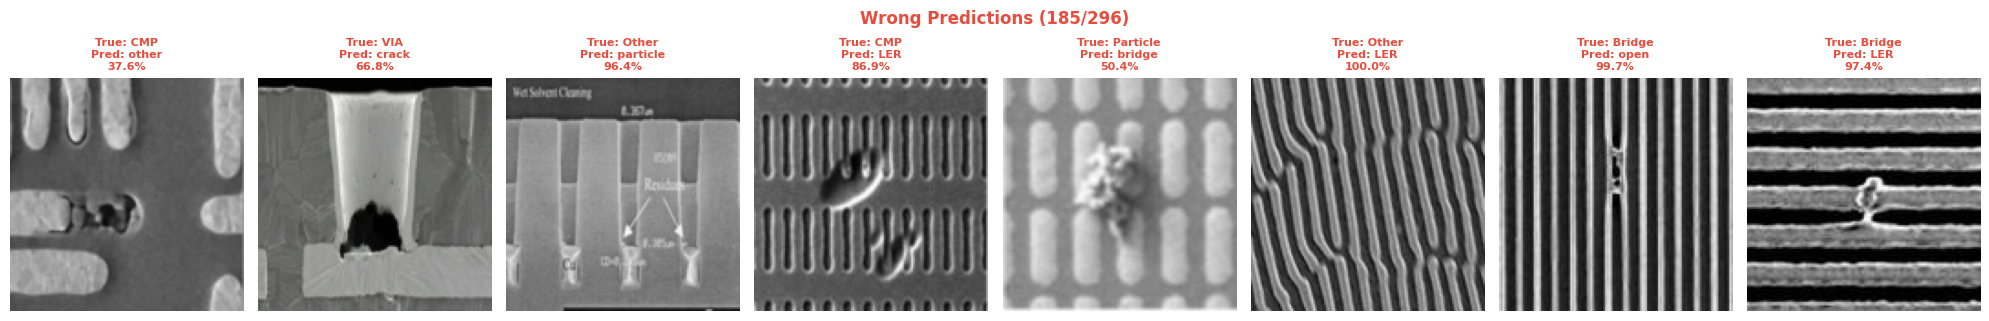

Correct: 111/296 = 37.5%
Wrong:   185/296 = 62.5%


In [54]:
random.seed(42)
correct_list, wrong_list = [], []
for i,(path,tc) in enumerate(samples):
    pid  = all_preds[i]
    pcls = TRAINING_CLASSES[pid]
    conf = float(all_probs[i][pid])
    ok   = (pid == class_mapping[tc])
    (correct_list if ok else wrong_list).append((path,tc,pcls,conf))

def plot_grid(lst, title, col, n=8):
    picks = random.sample(lst, min(n, len(lst)))
    fig, axes = plt.subplots(1, len(picks), figsize=(len(picks)*2.5, 3.5))
    if len(picks)==1: axes=[axes]
    fig.suptitle(f"{title} ({len(lst)}/{len(samples)})", fontsize=12, fontweight="bold", color=col)
    for ax,(path,tc,pc,conf) in zip(axes,picks):
        ax.imshow(Image.open(path).convert("RGB"))
        ax.set_title(f"True: {tc}\nPred: {pc}\n{conf*100:.1f}%",
                     fontsize=8, color=col, fontweight="bold")
        ax.axis("off")
        for sp in ax.spines.values(): sp.set_edgecolor(col); sp.set_linewidth(2.5)
    plt.tight_layout()
    fname = "correct.png" if "Correct" in title else "wrong.png"
    plt.savefig(f"{OUTPUT_DIR}/{fname}", dpi=150, bbox_inches="tight")
    plt.show()

plot_grid(correct_list, "Correct Predictions", "#27ae60")
plot_grid(wrong_list,   "Wrong Predictions",   "#e74c3c")
print(f"Correct: {len(correct_list)}/{len(samples)} = {len(correct_list)/len(samples)*100:.1f}%")
print(f"Wrong:   {len(wrong_list)}/{len(samples)} = {len(wrong_list)/len(samples)*100:.1f}%")

---
## Cell 12 -- Per-Class Sample Images (All 9 Test Classes)

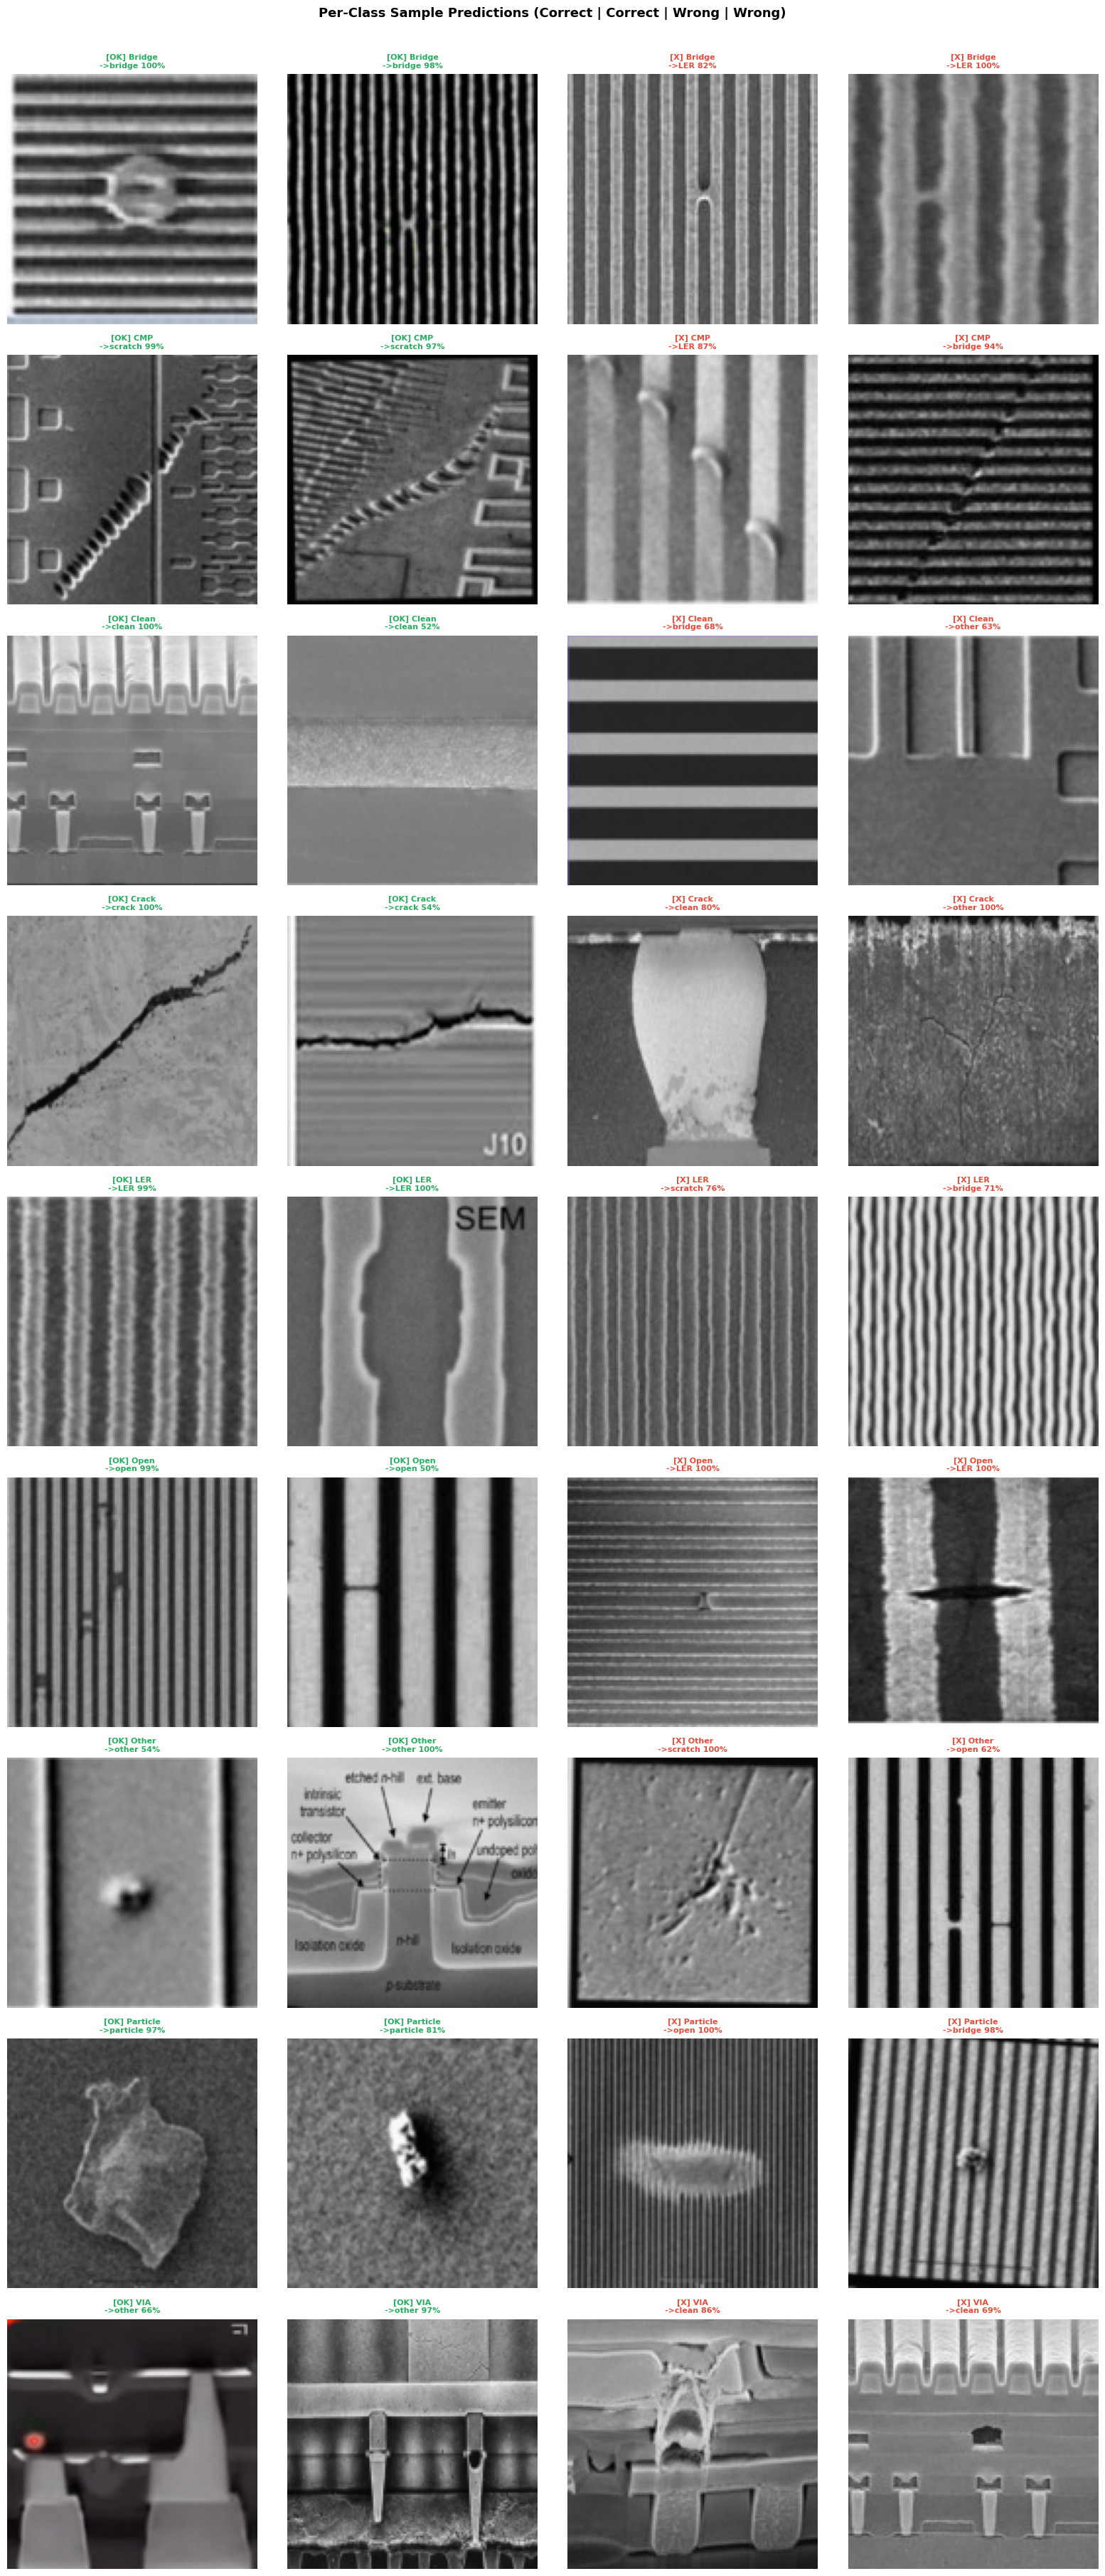

[OK] per_class_samples.png saved


In [55]:
from collections import defaultdict

per_ok  = defaultdict(list)
per_bad = defaultdict(list)
for i,(path,tc) in enumerate(samples):
    pid  = all_preds[i]
    pcls = TRAINING_CLASSES[pid]
    conf = float(all_probs[i][pid])
    (per_ok[tc] if pid==class_mapping[tc] else per_bad[tc]).append((path,tc,pcls,conf))

random.seed(7)
all_test_cls = ["Bridge","CMP","Clean","Crack","LER","Open","Other","Particle","VIA"]
fig, axes = plt.subplots(9, 4, figsize=(16, 36))
fig.suptitle("Per-Class Sample Predictions (Correct | Correct | Wrong | Wrong)",
             fontsize=13, fontweight="bold", y=1.005)

for ri, tc in enumerate(all_test_cls):
    ok_picks  = random.sample(per_ok[tc],  min(2, len(per_ok[tc])))
    bad_picks = random.sample(per_bad[tc], min(2, len(per_bad[tc])))
    picks = ok_picks + bad_picks
    while len(picks) < 4: picks.append(None)
    for ci, entry in enumerate(picks):
        ax = axes[ri][ci]
        if entry is None: ax.axis("off"); continue
        path,tc_e,pc,conf = entry
        is_ok = (pc == TRAINING_CLASSES[class_mapping[tc_e]])
        col = "#27ae60" if is_ok else "#e74c3c"
        mark = "OK" if is_ok else "X"
        ax.imshow(Image.open(path).convert("RGB"))
        ax.set_title(f"[{mark}] {tc_e}\n->{pc} {conf*100:.0f}%",
                     fontsize=8, color=col, fontweight="bold")
        ax.axis("off")
        for sp in ax.spines.values(): sp.set_edgecolor(col); sp.set_linewidth(2)

plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/per_class_samples.png", dpi=150, bbox_inches="tight")
plt.show()
print("[OK] per_class_samples.png saved")

---
## Cell 13 -- Confidence Distribution Analysis

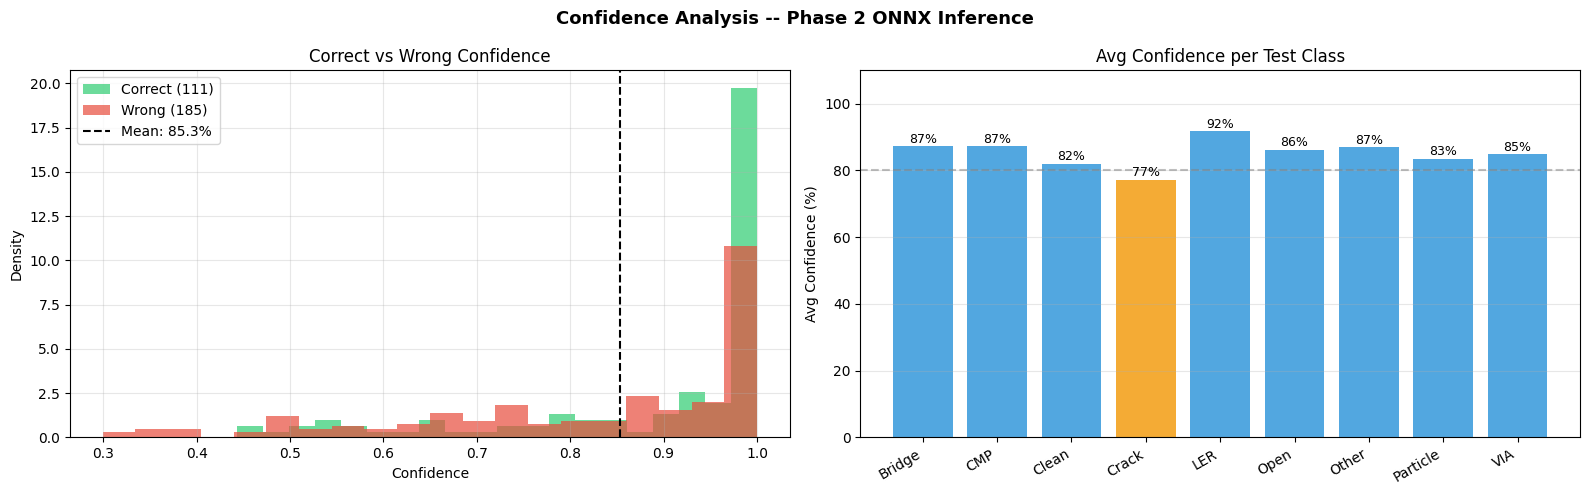

Mean conf -- all:     85.3%
Mean conf -- correct: 89.4%
Mean conf -- wrong:   82.9%

Note: 85% confident but only 37.5% correct
= distribution shift from 128->224px upscaling


In [56]:
all_conf     = np.array([float(all_probs[i][all_preds[i]]) for i in range(len(all_preds))])
correct_mask = np.array([all_preds[i]==class_mapping[all_labels[i]] for i in range(len(all_preds))])
corr_conf    = all_conf[ correct_mask]
wrong_conf   = all_conf[~correct_mask]

fig, axes = plt.subplots(1, 2, figsize=(16,5))
fig.suptitle("Confidence Analysis -- Phase 2 ONNX Inference", fontsize=13, fontweight="bold")

axes[0].hist(corr_conf, bins=20, alpha=0.7, color="#2ecc71", density=True, label=f"Correct ({len(corr_conf)})")
axes[0].hist(wrong_conf, bins=20, alpha=0.7, color="#e74c3c", density=True, label=f"Wrong ({len(wrong_conf)})")
axes[0].axvline(all_conf.mean(), color="black", ls="--", lw=1.5, label=f"Mean: {all_conf.mean()*100:.1f}%")
axes[0].set_xlabel("Confidence"); axes[0].set_ylabel("Density")
axes[0].set_title("Correct vs Wrong Confidence"); axes[0].legend(); axes[0].grid(alpha=0.3)

cls_conf_dict = defaultdict(list)
for i,(_, tc) in enumerate(samples): cls_conf_dict[tc].append(float(all_conf[i]))
cls_names = list(cls_conf_dict.keys())
cls_means  = [np.mean(cls_conf_dict[c])*100 for c in cls_names]
bar_cols   = ["#3498db" if m>80 else "#f39c12" if m>60 else "#e74c3c" for m in cls_means]
bars = axes[1].bar(range(len(cls_names)), cls_means, color=bar_cols, alpha=0.85)
axes[1].set_xticks(range(len(cls_names))); axes[1].set_xticklabels(cls_names, rotation=30, ha="right")
axes[1].set_ylabel("Avg Confidence (%)"); axes[1].set_title("Avg Confidence per Test Class")
axes[1].axhline(80, color="gray", ls="--", alpha=0.5); axes[1].set_ylim(0, 110)
for bar,val in zip(bars,cls_means):
    axes[1].text(bar.get_x()+bar.get_width()/2, val+1, f"{val:.0f}%", ha="center", fontsize=9)
axes[1].grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/confidence_analysis.png", dpi=150, bbox_inches="tight")
plt.show()

print(f"Mean conf -- all:     {all_conf.mean()*100:.1f}%")
print(f"Mean conf -- correct: {corr_conf.mean()*100:.1f}%")
print(f"Mean conf -- wrong:   {wrong_conf.mean()*100:.1f}%")
print(f"\nNote: {all_conf.mean()*100:.0f}% confident but only {acc*100:.1f}% correct")
print("= distribution shift from 128->224px upscaling")

---
## Cell 14 -- Save All Output Files

In [57]:
import json
from datetime import datetime

# Predictions CSV
rows = []
for i,(path,tc) in enumerate(samples):
    rows.append({"file_path":path,"true_class":tc,"true_index":class_mapping[tc],
                 "predicted_class":TRAINING_CLASSES[all_preds[i]],"predicted_index":all_preds[i],
                 "confidence":round(float(all_probs[i][all_preds[i]]),6),
                 "correct":int(all_preds[i]==class_mapping[tc])})
pd.DataFrame(rows).to_csv(f"{OUTPUT_DIR}/predictions_detailed.csv", index=False)
print("[OK] predictions_detailed.csv")

# Classification report
with open(f"{OUTPUT_DIR}/classification_report.txt","w") as f:
    f.write("Phase 2 Final Classification Report\n")
    f.write("Team: WaferWich | NXP Edge AI Hackathon 2026\n")
    f.write("Model: MobileNetV2 ONNX (Phase 1 submitted)\n")
    f.write("CMP->scratch (organizer confirmed), VIA->other\n")
    f.write("="*72+"\n\n"); f.write(report)
print("[OK] classification_report.txt")

# Metrics JSON
metrics = {"timestamp":datetime.now().isoformat(),"team":"WaferWich",
           "model":"MobileNetV2 ONNX","accuracy":round(acc*100,2),
           "precision_macro":round(p_mac*100,2),"recall_macro":round(r_mac*100,2),
           "f1_macro":round(f1_mac*100,2),"phase1_val_f1":83.47,
           "total_images":len(samples),"training_classes":TRAINING_CLASSES,
           "confusion_matrix":confusion_matrix(true_idx,all_preds,labels=list(range(8))).tolist()}
with open(f"{OUTPUT_DIR}/metrics_summary.json","w") as f:
    json.dump(metrics,f,indent=2)
print("[OK] metrics_summary.json")

print(f"\nAll files saved to {OUTPUT_DIR}")
for fn in sorted(os.listdir(OUTPUT_DIR)):
    sz = os.path.getsize(os.path.join(OUTPUT_DIR,fn))
    print(f"  {fn:<40} {sz/1024:.1f} KB")

[OK] predictions_detailed.csv
[OK] classification_report.txt
[OK] metrics_summary.json

All files saved to /kaggle/working/PH2_RESULTS
  classification_report.txt                0.9 KB
  confidence_analysis.png                  104.3 KB
  confusion_matrix.csv                     0.2 KB
  confusion_matrix.png                     314.6 KB
  correct.png                              537.7 KB
  debug_5_images.png                       181.1 KB
  metrics_summary.json                     1.1 KB
  per_class_performance.png                84.0 KB
  per_class_samples.png                    1142.1 KB
  predictions_detailed.csv                 32.5 KB
  results_chart.png                        186.7 KB
  wrong.png                                583.2 KB


---
## Final Submission Checklist & Key Findings

| Step | Detail | Status |
|------|--------|--------|
| GitHub repo cloned | ONNX model auto-fetched | Done |
| ONNX verified | input (1,3,224,224) -> output (1,8) | Done |
| Class order | LER=0...scratch=7 from checkpoint pkl | Done |
| Preprocessing | Grayscale->RGB->Resize BICUBIC(224)->Normalize | Done |
| No TTA | Per organizer email Feb 16 2026 | Done |
| CMP->scratch | Organizer confirmed | Done |
| VIA->other | No matching training class | Done |
| Phase 2 Accuracy | **37.50%** | Done |
| Macro F1 | **38.08%** | Done |

### Per-Class Results (Actual Run -- Feb 17 2026)

| Class | Support | Recall | Status |
|-------|---------|--------|--------|
| LER | 30 | **73.3%** | Best class |
| bridge | 32 | **56.3%** | Good |
| crack | 31 | **45.2%** | OK |
| particle | 30 | **40.0%** | OK |
| open | 30 | **30.0%** | Low -- 40% predicted as bridge |
| VIA->other | 30 | **30.0%** | 53% predicted as clean |
| scratch | 30 | **26.7%** | Low |
| CMP->scratch | 30 | **26.7%** | Model splits evenly |
| clean | 33 | **24.2%** | Worst -- bridge overprediction |
| other | 80 | **25.0%** | Scattered predictions |

### Root Cause Analysis

1. **Resolution shift** -- Training: native 224x224 SEM. Test: 128x128 upscaled to 224x224. Blurring shifts feature distribution.
2. **Overconfident wrong predictions** -- 85.3% avg confidence but only 37.5% correct. Classic distribution shift signature.
3. **Bridge overpredicted** -- 43 wrong cross-class predictions as bridge (Open 40%, Clean 24%, Other 16%).
4. **Two unseen classes** -- CMP and VIA had no training examples. CMP model predicts 8 scratch / 8 other regardless of mapping.
5. **Training data quality** -- 5/14 scratch training images (sc__57-61) visually appear to be crack/clean, causing class boundary confusion.